In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import scale
import scipy.ndimage

In [33]:
labels = np.load("notMNIST/train_labels.npy")
train_images = np.load("notMNIST/train_images.npy")
test_images = np.load("notMNIST/test_images.npy")
label_names = np.array(['A','B','C','D','E','F','G','H','I','J'])

In [34]:
print("There are "+str(train_images.shape[0]) + " images in the dataset")
print("The dimensions of each image are "+str(train_images.shape[1])+" by "+ str(train_images.shape[2]))
print(test_images.shape)

There are 100 images in the dataset
The dimensions of each image are 28 by 28
(100, 28, 28)


In [4]:
def get_image_and_label(image_number):
    plt.matshow(train_images[image_number], cmap=plt.cm.gray)
    print(label_names[labels[image_number]])

def show_image(image):
        plt.matshow(image, cmap=plt.cm.gray)

In [5]:
'''
#Demonstration Code


print("Origional image")
show_image(train_images[0])
print("Downscaled by 1/2")
show_image(scipy.ndimage.zoom(train_images[0],.5))
print("Upscaled back to origional")
show_image(scipy.ndimage.zoom(scipy.ndimage.zoom(train_images[0],.5),2))
'''

'\n#Demonstration Code\n\n\nprint("Origional image")\nshow_image(images[0])\nprint("Downscaled by 1/2")\nshow_image(scipy.ndimage.zoom(images[0],.5))\nprint("Upscaled back to origional")\nshow_image(scipy.ndimage.zoom(scipy.ndimage.zoom(images[0],.5),2))\n'

In [9]:
downscaled_images = np.array([scipy.ndimage.zoom(i,.5) for i in train_images])
print(downscaled_images.shape)
print(train_images.shape)

(100, 14, 14)
(100, 28, 28)


In [24]:
small_input = tf.constant(downscaled_images, dtype = 'float32', shape = [100, 14, 14])
large_prediction = tf.constant(train_images, dtype = 'float32', shape = [100, 28, 28])

small_flattened = tf.reshape(small_input,[-1,14*14])
large_flattened = tf.reshape(large_prediction,[-1,28*28])

#x_test_images = tf.constant(test_images, dtype = 'float32', shape = [100, 784])
#y_test_labels = tf.constant(test_labels, dtype = 'float32', shape = [100,10])

w = tf.Variable(tf.truncated_normal([14*14, 28*28]))
b = tf.Variable(tf.truncated_normal([1,28*28]))

MSE = tf.reduce_mean(tf.square(tf.matmul(small_flattened,w)+b -large_flattened))
#MSE_test = tf.reduce_mean(tf.square(tf.nn.softmax(tf.matmul(x_test_images,w)+b) -y_test_labels))
train_pred = tf.reshape(tf.matmul(small_flattened,w)+b,[-1,28,28])
#test_pred = tf.nn.softmax(tf.matmul(x_test_images,w)+b)

optimizer = tf.train.AdamOptimizer().minimize(MSE)

#y_pred = tf.nn.softmax(tf.matmul(x_test_images,w) + b)
init = tf.initialize_all_variables()

In [25]:
sess = tf.Session()
sess.run(init)

In [27]:
MAXSTEPS = 2000
for step in range(MAXSTEPS):
    (_,mse,w0,b0) = sess.run([optimizer,MSE,w,b])
    if (step % 300)==0:
        pred = sess.run(train_pred)
        print('step = %-5d MSE = %-10f' % (step,mse))
print("Done!")

step = 0     MSE = 0.427480  
step = 300   MSE = 0.311291  
step = 600   MSE = 0.230594  
step = 900   MSE = 0.172918  
step = 1200  MSE = 0.130796  
step = 1500  MSE = 0.099528  
step = 1800  MSE = 0.076030  
Done!


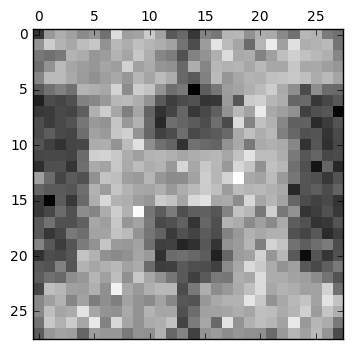

In [32]:
pred = sess.run(train_pred)
show_image(pred[3])